# Tarea 06: DBSCAN

Encontrar una pareja (eps, min) que consiga que la silhouette del modelo DBSCAN, aplicado a la tabla datos_circulares.csv, sea mayor a 0.7 y separe los dos anillos.

In [1]:
# Importamos las librerías estandar para manipular nuestro dataframe

import pandas as pd
import numpy as np
from siuba import *
from siuba.dply.vector import *
from plotnine import *
from sklearn import preprocessing
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
######### Importar datos ##########

# Importamos la tabla datos_circulares.csv desde Github
mi_data = pd.read_csv("https://raw.githubusercontent.com/scidatmath2020/ML_Py_23/main/data/datos_circulares.csv")

# Visualizamos las primeras 5 filas
mi_data.head()

,columna1,columna2
0,0.937886,-0.528235
1,0.250962,0.037586
2,0.053985,0.236188
3,0.665086,-0.809979
4,-0.178781,0.198252


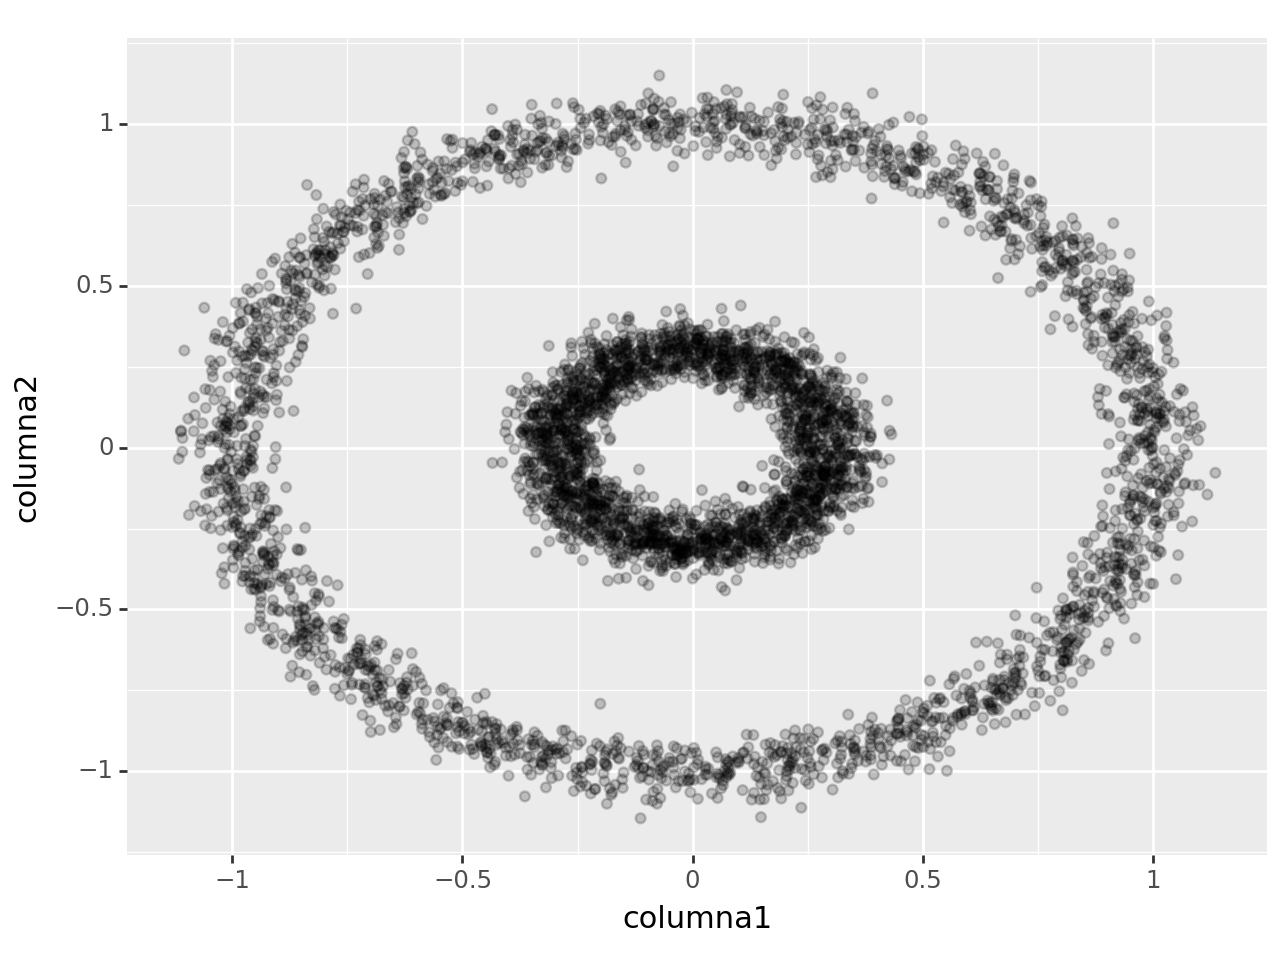

<Figure Size: (640 x 480)>

In [3]:
# Tenemos dos columnas, así que podemos graficar los datos para tener una mejor idea de los mismos 
(ggplot(data = mi_data) 
 + geom_point(mapping=aes(x="columna1", y="columna2"), alpha=0.2) 
)

0.4800998831041985


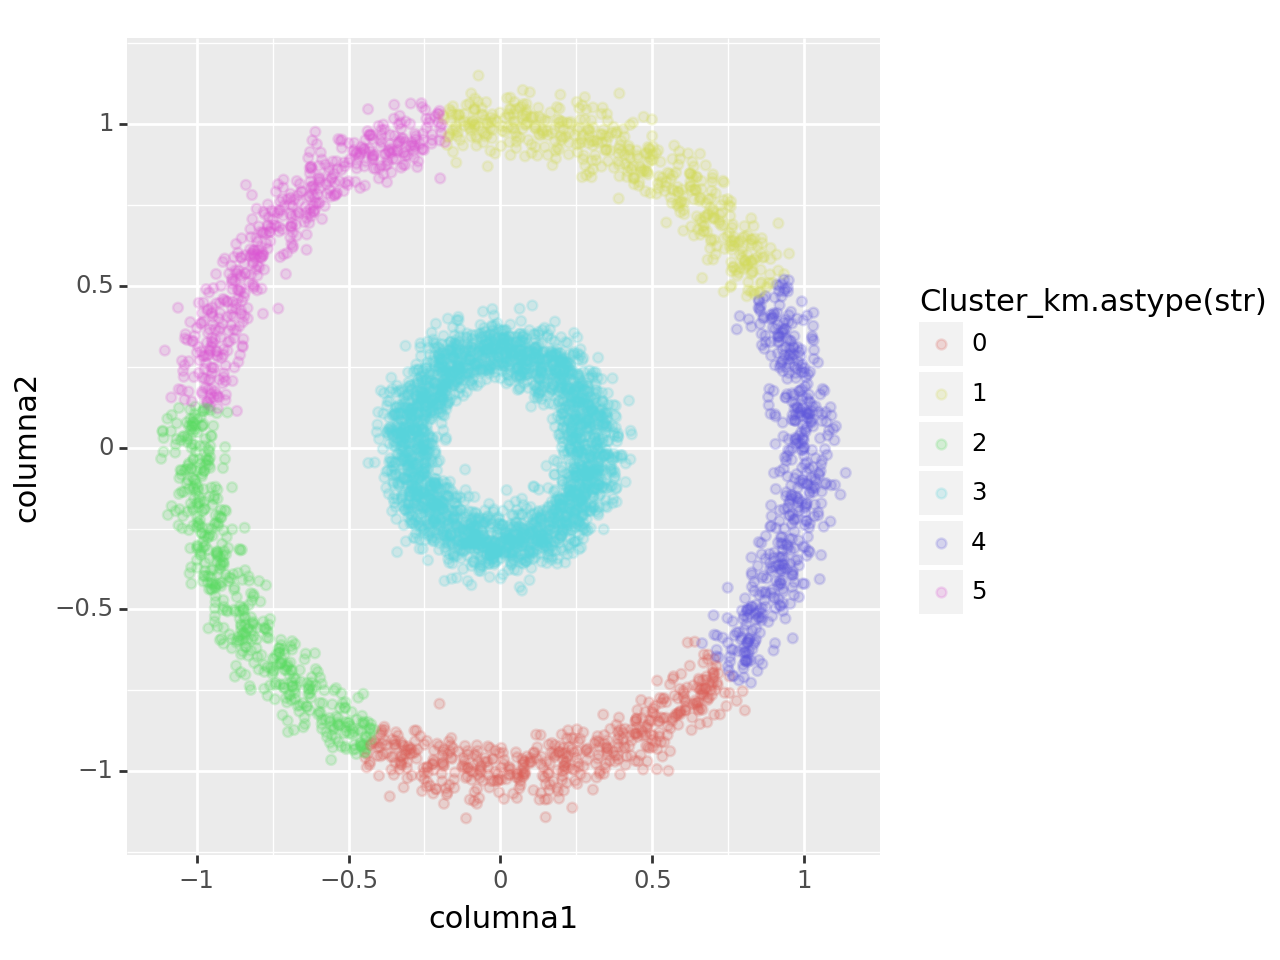

<Figure Size: (640 x 480)>

In [4]:
######### Aplicación de K-medias ##########

# Vamos a aplicar el modelo de K-medias al dataset para 
# poder comparar los resultados con BDSCAN
# Primero importamos el modelo y las métricas
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Definimos y entrenamos el modelo, con parámetros arbitrarios
model_km = KMeans(n_clusters = 6, init='k-means++', n_init = 10)
model_km.fit(mi_data)

# Pedidos las etiquetas para el dataset
labels_km = model_km.labels_ 

# Imprimimos el valor de la silhouette
print(silhouette_score(mi_data, labels_km))

# Volvemos a graficar los datos, ahora usando las etiquetas encontradas con K-medias
(mi_data >> mutate(Cluster_km = labels_km) >>
     ggplot() 
     + geom_point(mapping=aes(x="columna1", y="columna2", color="Cluster_km.astype(str)"), alpha=0.2) 
)

0.2090022950602488


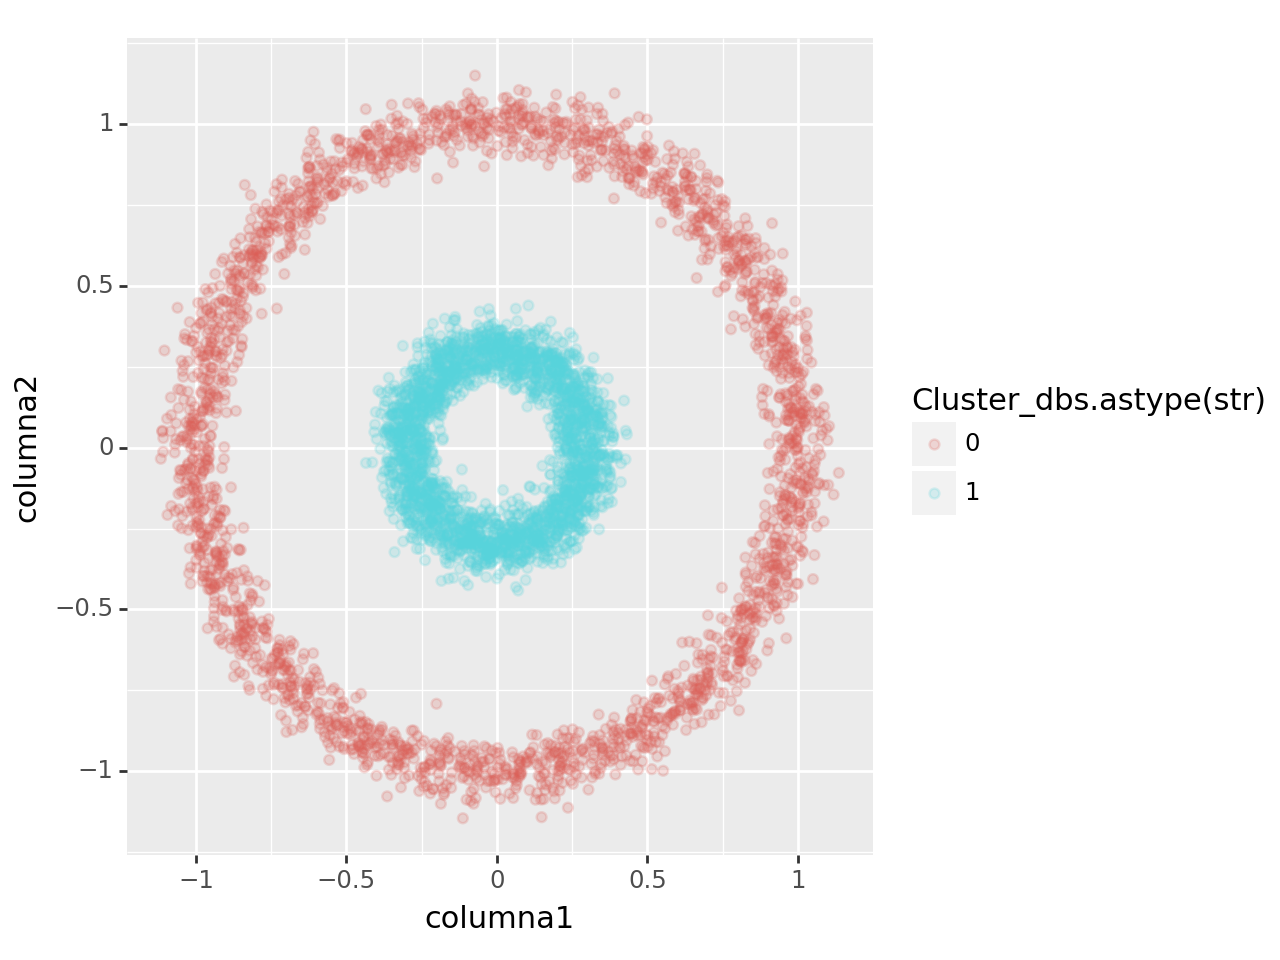

<Figure Size: (640 x 480)>

In [5]:
# Ahora aplicamos DBSCAN a los datos. Definimos al modelo usando primero 
# los parámetros usados en la clase
model_dbscan = DBSCAN(eps=0.33, min_samples=21)
# Entrenamos y obtenemos las etiquetas
labels_dbscan = model_dbscan.fit(mi_data).labels_
# Imprimimos el valor de la silhouette
print(silhouette_score(mi_data, labels_dbscan))
# Finalmente graficamos los datos, ahora adjuntando las etiquetas
# encontradas con DBSCAN
(mi_data >> mutate(Cluster_dbs = labels_dbscan) >>
     ggplot() 
     + geom_point(mapping=aes(x="columna1", y="columna2", color = "Cluster_dbs.astype(str)"), alpha=0.2) 
)

Como vemos, la silhouette encontrada con DBSCAN es menor que lo encontrado con K-medias. Pero parecería que la clusterización es mejor usando DBSCAN. Así que, primero busquemos los hiperparámetros que incrementen el valor de la silueta con BDSCAN. Al menos, para obtener un valor mayor a los de K-medias. 

In [6]:
# Definimos la siguiente función, que nos regresa la silhouette variando los hiperparámetros eps y min_sample
# en DBSCAN. 
def siluetas_dbscan(e_p_s, m_i_n):
    try:
        dbscan = DBSCAN(eps= e_p_s, min_samples= m_i_n)
        lab_dbscan = dbscan.fit(mi_data).labels_
        return silhouette_score(mi_data, lab_dbscan)   
    except:
        return 0.0

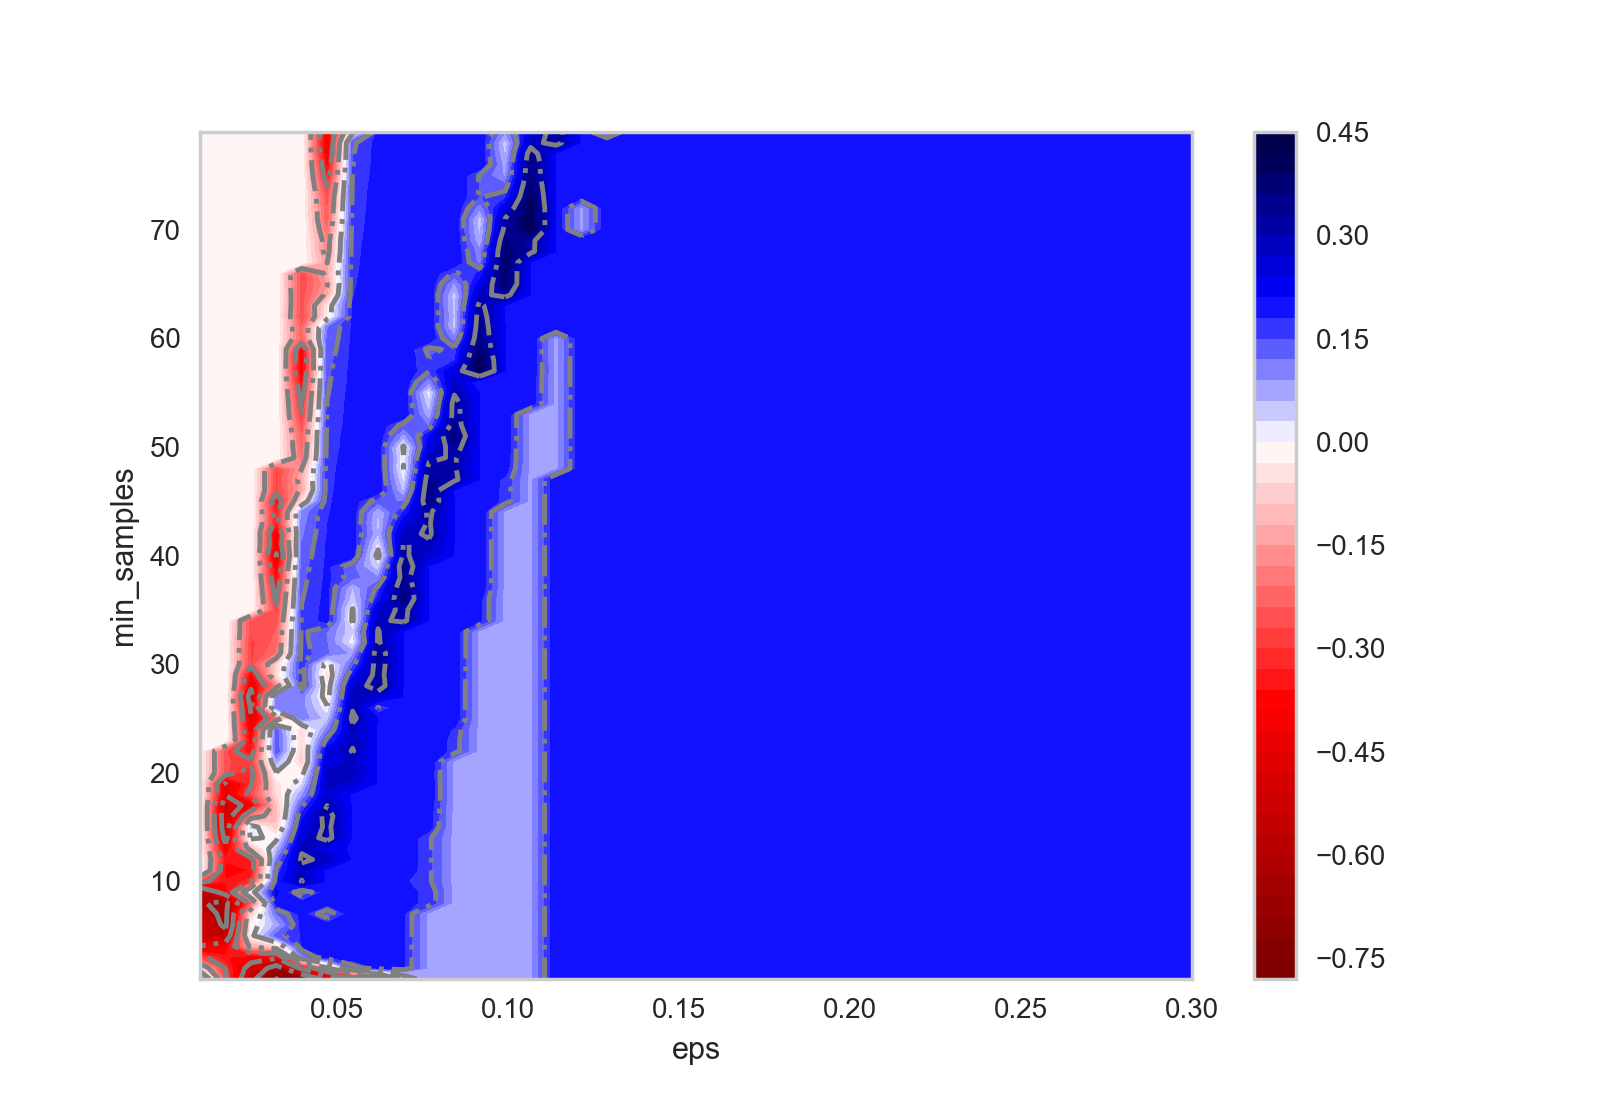

In [20]:
# Graficaremos la función anterior usando una gráfica de contorno en 2D
# Y para ello usaremos matplotlib. 
%matplotlib inline
import matplotlib.pyplot as plt

# Como paleta de colores usaremos 'seismic_r'. Que pinta de rojo, los valores
# debajo de la media. Y de azul por arriba de la media. Para elegir el valor
# medio de la paleta de colores, usamos la siguiente clase.
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Aquí definimos la tabla de valores de eps
eps_val = np.linspace(0.01, 0.30, 40)
# Aquí definimos la tabla de valores de min_samples
min_val = np.arange(1, 80, 1)

# Los valores anteriores los definimos en cada punto de la gráfica 2D
X, Y = np.meshgrid(eps_val, min_val)

# Evaluamos la función en cada punto
Z = np.array([[siluetas_dbscan(x, y) for x in eps_val] for y in min_val])

# Ahora podemos graficar
fig, ax = plt.subplots()
# Definimos el valor mínimo de la barra de colores
elev_min = np.amin(Z)
# Definimos el valor máximo de la barra de colores
elev_max = np.amax(Z)
# # Definimos el valor medio de la barra de colores
mid_val = 0.0

# Graficamos
plt.contourf(X, Y, Z, 40, cmap = 'seismic_r', norm=MidpointNormalize(midpoint=mid_val, vmin=elev_min, vmax=elev_max))
ax.contour(X, Y, Z, 7, colors = 'gray', linestyles = 'dashdot')
# Pedimos la barra de colores de la gráfica
plt.colorbar()
plt.xlabel(r'eps');
plt.ylabel(r'min_samples');

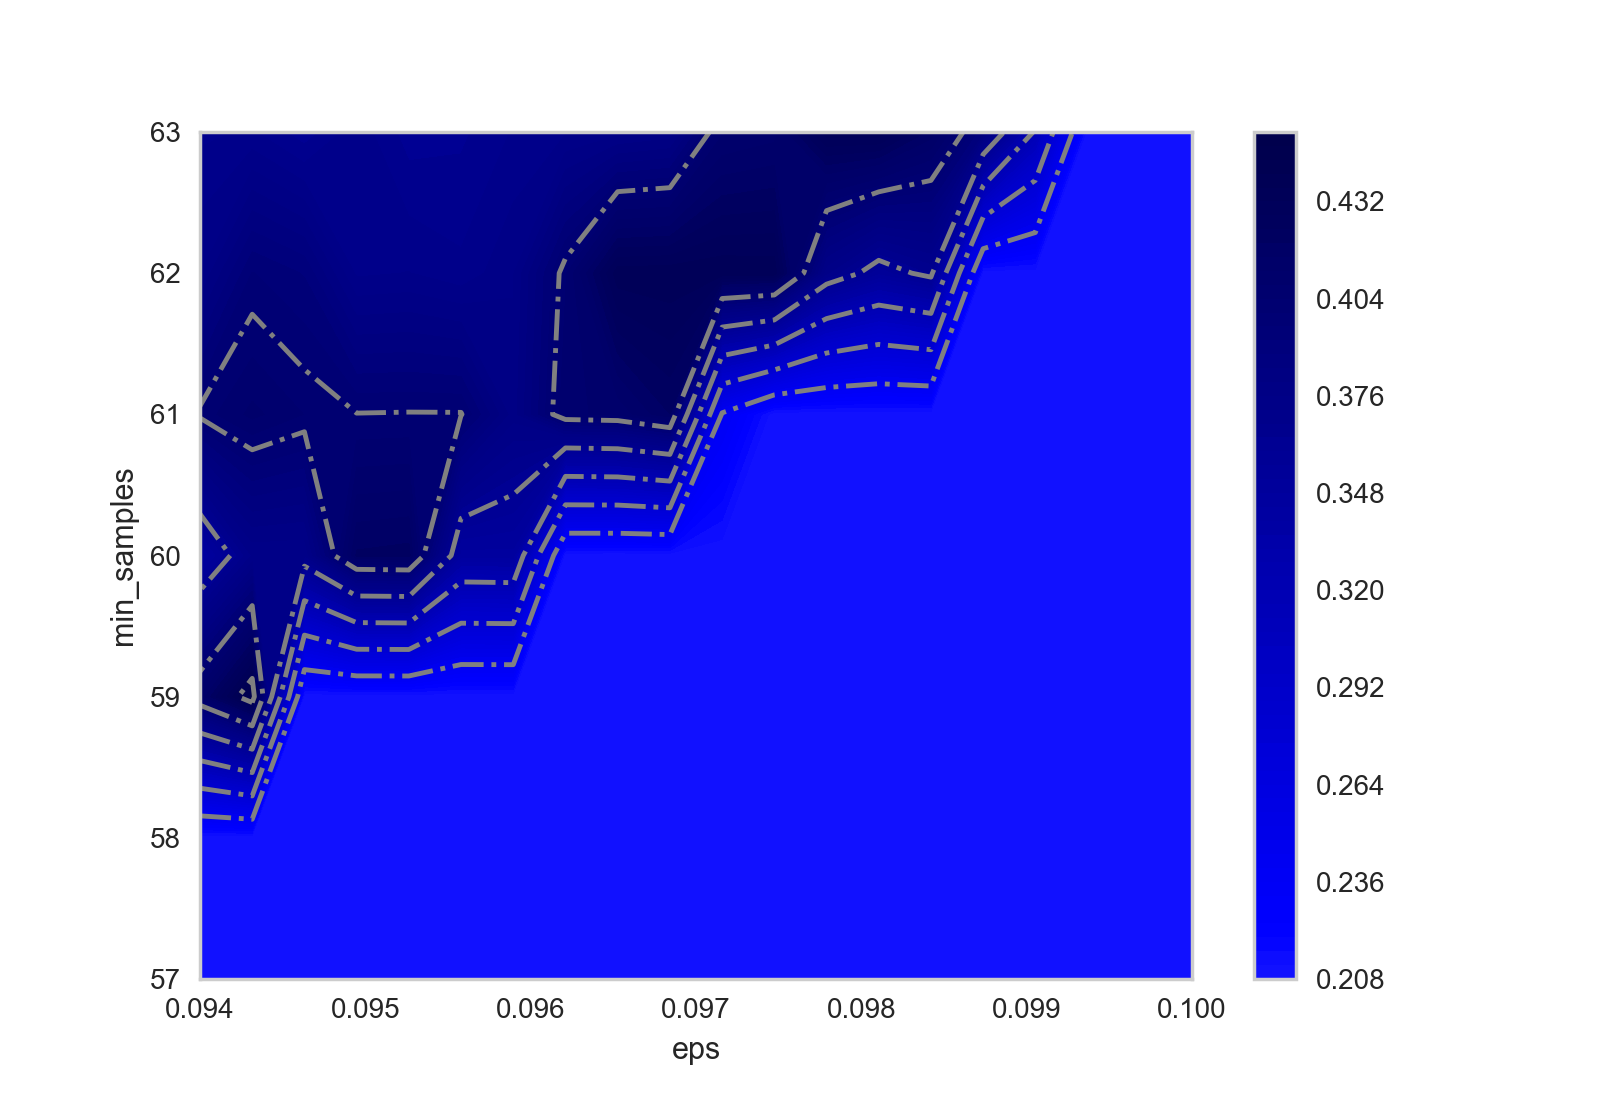

In [42]:
# Refinamos la busqueda
eps_val = np.linspace(0.094, 0.10, 20)
min_val = np.arange(57, 64, 1)
X, Y = np.meshgrid(eps_val, min_val)
Z = np.array([[siluetas_dbscan(x, y) for x in eps_val] for y in min_val])

# Ahora podemos graficar
fig, ax = plt.subplots()
elev_min = np.amin(Z)
elev_max = np.amax(Z)
mid_val = 0.0

# Graficamos
plt.contourf(X, Y, Z, 60, cmap = 'seismic_r', norm=MidpointNormalize(midpoint=mid_val, vmin=elev_min, vmax=elev_max))
ax.contour(X, Y, Z, 7, colors = 'gray', linestyles = 'dashdot')
plt.colorbar()
plt.xlabel(r'eps');
plt.ylabel(r'min_samples');

In [7]:
# Verificamos la silhouette para valores (eps, min_samples)
siluetas_dbscan(0.0944, 59)

0.45029160449540606

De la búsqueda anterior, vemos que hay hiperparámetros con silhouette de aproximadamente 0.45. Veamos como se comporta DBSCAN en alguno de estos.

0.45029160449540606


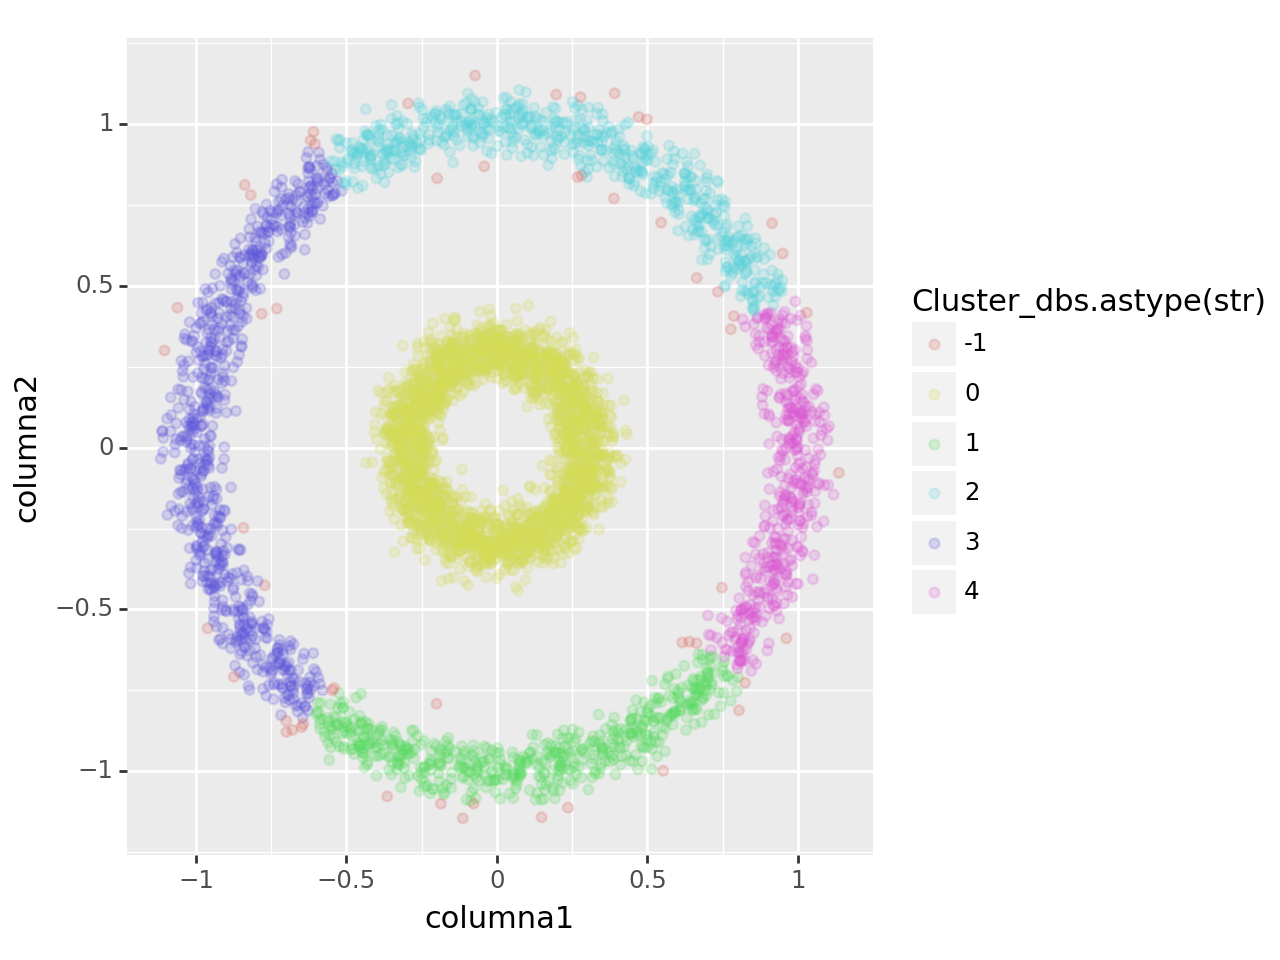

<Figure Size: (640 x 480)>

In [7]:
# Ahora aplicamos DBSCAN a los datos. Definimos al modelo 
model_dbscan_best = DBSCAN(eps=0.0944, min_samples=59)
# Entrenamos y obtenemos las etiquetas
labels_dbscan_best = model_dbscan_best.fit(mi_data).labels_
# Imprimimos la silueta
print(silhouette_score(mi_data, labels_dbscan_best))
# Finalmente imprimos los datos, ahora adjuntando las etiquetas
# encontradas con DBSCAN
(mi_data >> mutate(Cluster_dbs = labels_dbscan_best) >>
     ggplot() 
     + geom_point(mapping=aes(x="columna1", y="columna2", color = "Cluster_dbs.astype(str)"), alpha=0.2) 
)

De la gráfica anterior, aunque ya tengamos un mejor valor de silhouette, parece que la clusterización
de DBSCAN no es lo que esperaríamos. Esto puede ser porque silhouette no es una buena medida cuando
tenemos clusters no convexos (checar: https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index, sección 2.3.11.5).

Pero, podemos obtar por otra medida. Una de ellas es DBCV (https://github.com/christopherjenness/DBCV) y otra es CDbw (https://medium.com/@giannispoy/is-silhouette-the-right-clustering-evaluation-metric-for-you-dcfdbb268be4)

In [30]:
# Silhouette no va bien con clusters no-convexos. Por tanto vamos a usar otro método de validación.
# El siguiente se llama 'DBCV'. Para llamarla debemos de instalar la librería 'hdbscan'. Para ello
# podemos hacer 'pip install hdbscan'. Luego de instalar, hacemos
import hdbscan

# El score del primero modelo
dbcv_score = hdbscan.validity.validity_index(mi_data.values, labels_dbscan)
# El score del segundo modelo, que tienen un mayor valor de silhouette
dbcv_score_best = hdbscan.validity.validity_index(mi_data.values, labels_dbscan_best)

# Imprimimos los valores y veremos que bajo el nuevo score, el primer modelo separa mejor
print(dbcv_score)
print(dbcv_score_best)

0.5051692662003624
0.09963382922718042


Bajo la nueva métrica, vemos que es el primer modelo de DBSCAN el que tiene una validación más alta que la segunda.